[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1SH-BWkdQ4KGngpy_yT0fjrlRPDknGlz0?usp=share_link)

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt

tf.enable_v2_behavior()

BATCH_SIZE = 32

import pandas as pd
import os
import glob
from google.colab import files
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn import preprocessing
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
!pip install keras-flops
from keras_flops import get_flops
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Data Loading

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
project_path = '/content/gdrive/MyDrive/ECE1512/ProjectA'
annotations = pd.read_csv(project_path + '/mhist_dataset/annotations.csv')
annotations.set_index('Image Name', inplace=True)
images_path = '/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images'
images_name = os.listdir(images_path)

In [6]:
mhist_train_label = []      #WITHOUT data augmentation
mhist_train_img = []
mhist_test_img = []
mhist_test_label = []

with tf.device('/device:GPU:0'):
  for img in images_name:

    if annotations.loc[img]['Partition'] == 'train':
        img_train_origin = Image.open('/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images/' + img)
        img_train_data = np.asarray(img_train_origin)
        mhist_train_img.append(img_train_data)
        img_train_label = annotations.loc[img]['Majority Vote Label']
        mhist_train_label.append(img_train_label)

    if annotations.loc[img]['Partition'] == 'test':
        img_test_origin = Image.open('/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images/' + img)
        img_test_data = np.asarray(img_test_origin)
        mhist_test_img.append(img_test_data)        
        img_label = annotations.loc[img]['Majority Vote Label']
        mhist_test_label.append(img_label)

In [7]:
mhist_train_img = np.array(mhist_train_img)
mhist_train_label = np.array(mhist_train_label)
mhist_test_img = np.array(mhist_test_img)
mhist_test_label = np.array(mhist_test_label)
mhist_train_img = mhist_train_img/255
mhist_test_img = mhist_test_img/255
le = preprocessing.LabelEncoder()
le.fit(mhist_train_label)
mhist_train_label_le = le.transform(mhist_train_label)
mhist_test_label_le = le.transform(mhist_test_label)

#Teacher

##Model Setup

In [84]:
def teacher_initial():
  Res = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(224, 224, 3))
  #Res.trainable = False
  for layer in Res.layers[:185]:
    layer.trainable = False
  for layer in Res.layers[-5:]:
    layer.trainable = True

  average_tea = tf.keras.layers.GlobalAveragePooling2D()(Res.output)
  dense_tea = tf.keras.layers.Dense(1024, activation = 'tanh')(average_tea)
  dense_tea = tf.keras.layers.Dense(512, activation = 'tanh')(dense_tea)
  dense_tea = tf.keras.layers.Dense(256, activation = 'tanh')(dense_tea)
  dense_tea = tf.keras.layers.Dense(128, activation = 'tanh')(dense_tea)
  dense_tea = tf.keras.layers.Dense(64, activation = 'tanh')(dense_tea)
  dense_tea = tf.keras.layers.Dense(32, activation = 'ReLU')(dense_tea)
  dense_tea = tf.keras.layers.Dense(16, activation = 'ReLU')(dense_tea)
  dense_tea = tf.keras.layers.Dense(8, activation = 'ReLU')(dense_tea)
  dense_tea = tf.keras.layers.Dense(4, activation = 'ReLU')(dense_tea)
  dense_tea = tf.keras.layers.Dense(2, activation = 'sigmoid')(dense_tea)
  
  teacher_model = Model(inputs=Res.input, outputs=dense_tea)
  return teacher_model

In [130]:
teacher_model = teacher_initial()
teacher_model.summary()

Model: "model_65"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_69[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))

  return cross_entropy_loss_value

#Student

##Model Setup

In [98]:
# Build student.
def student_initial():
  Mob = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
  Mob.trainable = False
  '''for layer in Mob.layers[:149]:
    layer.trainable = False
  for layer in Mob.layers[-5:]:
    layer.trainable = True'''

  average_stu = tf.keras.layers.GlobalAveragePooling2D()(Mob.output)
  dense_stu = tf.keras.layers.Dense(2, activation = 'sigmoid')(average_stu)
  student_model = Model(inputs=Mob.input, outputs=dense_stu)
  return student_model

In [99]:
student_model = student_initial()
student_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

#Helper Function

In [106]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2


class KD(tf.keras.Model):
    def __init__(self, student, teacher):
        super(KD, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,alpha,temperature):
        super(KD, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            dis_loss = distillation_loss(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                student_predictions,
                temperature = self.temperature
            )
            loss_value = self.alpha * student_loss + (1 - self.alpha) * dis_loss

        gradients = tape.gradient(loss_value, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": dis_loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return y_prediction

#Training Process

##Train Teacher

In [86]:
teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train teacher on data.
teacher_model.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 5s 23ms/step - loss: 0.4916 - sparse_categorical_accuracy: 0.7186
Epoch 2/25
68/68 [==============================] - 2s 23ms/step - loss: 0.3498 - sparse_categorical_accuracy: 0.8501
Epoch 3/25
68/68 [==============================] - 2s 24ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.8929
Epoch 4/25
68/68 [==============================] - 2s 23ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.9356
Epoch 5/25
68/68 [==============================] - 2s 23ms/step - loss: 0.1401 - sparse_categorical_accuracy: 0.9480
Epoch 6/25
68/68 [==============================] - 2s 23ms/step - loss: 0.1110 - sparse_categorical_accuracy: 0.9651
Epoch 7/25
68/68 [==============================] - 2s 23ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9789
Epoch 8/25
68/68 [==============================] - 2s 23ms/step - loss: 0.0806 - sparse_categorical_accuracy: 0.9733
Epoch 9/25
68/68 [==============================] - 2s 2

In [87]:
tea_f1_score = f1_score(mhist_test_label_le, np.argmax(teacher_model.predict(mhist_test_img), axis=1))
print('Teachers f1 score is',tea_f1_score)
tea_auc = roc_auc_score(mhist_test_label_le, np.argmax(teacher_model.predict(mhist_test_img), axis=1))
print('Teachers auc is',tea_auc) #(2048-1024-512-256-128-64-32-16-8-4-2) (last 5 unfreeze) (5 tanh 4 relu last sigmoid)

31/31 [==============================] - 1s 19ms/step
Teachers f1 score is 0.7513368983957219
31/31 [==============================] - 1s 19ms/step
Teachers auc is 0.8035678912299657


##Train Student from Scratch

In [100]:
student_model = student_initial()

student_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train student from scratch
student_model.fit(mhist_train_img, mhist_train_label_le, steps_per_epoch=68, epochs=25)

Epoch 1/25
68/68 [==============================] - 3s 15ms/step - loss: 0.5116 - sparse_categorical_accuracy: 0.7503
Epoch 2/25
68/68 [==============================] - 1s 15ms/step - loss: 0.4018 - sparse_categorical_accuracy: 0.8110
Epoch 3/25
68/68 [==============================] - 1s 15ms/step - loss: 0.3764 - sparse_categorical_accuracy: 0.8239
Epoch 4/25
68/68 [==============================] - 1s 15ms/step - loss: 0.3476 - sparse_categorical_accuracy: 0.8414
Epoch 5/25
68/68 [==============================] - 1s 15ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.8441
Epoch 6/25
68/68 [==============================] - 1s 15ms/step - loss: 0.3236 - sparse_categorical_accuracy: 0.8538
Epoch 7/25
68/68 [==============================] - 1s 16ms/step - loss: 0.3214 - sparse_categorical_accuracy: 0.8598
Epoch 8/25
68/68 [==============================] - 1s 15ms/step - loss: 0.3085 - sparse_categorical_accuracy: 0.8584
Epoch 9/25
68/68 [==============================] - 1s 1

In [101]:
stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student f1 score is',stu_f1_score)
stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student auc is',stu_auc)

31/31 [==============================] - 1s 13ms/step
Student f1 score is 0.6927374301675977
31/31 [==============================] - 0s 13ms/step
Student auc is 0.7569241851251576


##Distill knowledge from Teacher to Student

In [113]:
student_model = student_initial()

distiller = KD(student=student_model, teacher=teacher_model)
distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.BinaryAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.5,
      temperature = 4,
  )

distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 6s 32ms/step - binary_accuracy: 0.4653 - student_loss: 0.5166 - distillation_loss: 11.1035
Epoch 2/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.4101 - student_loss: 0.3896 - distillation_loss: 11.1014
Epoch 3/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.3230 - student_loss: 0.3592 - distillation_loss: 11.0936
Epoch 4/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.2984 - student_loss: 0.3410 - distillation_loss: 11.0911
Epoch 5/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.2947 - student_loss: 0.3291 - distillation_loss: 11.0904
Epoch 6/25
68/68 [==============================] - 2s 32ms/step - binary_accuracy: 0.2917 - student_loss: 0.3155 - distillation_loss: 11.0901
Epoch 7/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.2913 - student_loss: 0.3066 - distillation_loss: 11.0900

In [ ]:
stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student f1 score is',stu_f1_score)
stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student auc is',stu_auc)

31/31 [==============================] - 0s 11ms/step
Student f1 score is 0.7090216010165183
31/31 [==============================] - 0s 11ms/step
Student auc is 0.7675648298217179


#Hyperparameters Tuning

Epoch 1/25
68/68 [==============================] - 6s 31ms/step - binary_accuracy: 0.4634 - student_loss: 0.4760 - distillation_loss: 0.6868
Epoch 2/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.4607 - student_loss: 0.3766 - distillation_loss: 0.6842
Epoch 3/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.4308 - student_loss: 0.3567 - distillation_loss: 0.6831
Epoch 4/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.3963 - student_loss: 0.3429 - distillation_loss: 0.6822
Epoch 5/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.3818 - student_loss: 0.3272 - distillation_loss: 0.6817
Epoch 6/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.3715 - student_loss: 0.3212 - distillation_loss: 0.6815
Epoch 7/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.3697 - student_loss: 0.3203 - distillation_loss: 0.6816
Epoch 

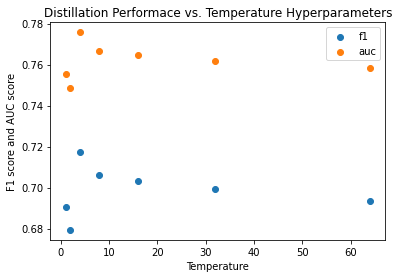

In [120]:
T = [1, 2, 4, 8, 16, 32, 64]
student_f1_list = []
student_auc_list = []
for temp in T:
  student_model = student_initial()
  distiller = KD(student=student_model, teacher=teacher_model)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.BinaryAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.5,
      temperature = temp,
  )
  distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

  stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
  stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))

  student_f1_list.append(stu_f1_score)
  student_auc_list.append(stu_auc)

  print(temp,'Temperature done')
print('student_f1_list is',student_f1_list)
print('student_auc_list is',student_auc_list)
plt.scatter(T, student_f1_list, label='f1')
plt.scatter(T, student_auc_list, label='auc')
plt.xlabel("Temperature")
plt.ylabel("F1 score and AUC score")
plt.title("Distillation Performace vs. Temperature Hyperparameters")
plt.legend()
plt.show()

Epoch 1/25
68/68 [==============================] - 6s 31ms/step - binary_accuracy: 0.6269 - student_loss: 0.5397 - distillation_loss: 11.0959
Epoch 2/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7085 - student_loss: 0.4040 - distillation_loss: 11.0901
Epoch 3/25
68/68 [==============================] - 2s 30ms/step - binary_accuracy: 0.7101 - student_loss: 0.3695 - distillation_loss: 11.0898
Epoch 4/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7099 - student_loss: 0.3525 - distillation_loss: 11.0898
Epoch 5/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7103 - student_loss: 0.3440 - distillation_loss: 11.0898
Epoch 6/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7103 - student_loss: 0.3286 - distillation_loss: 11.0897
Epoch 7/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7101 - student_loss: 0.3207 - distillation_loss: 11.0897

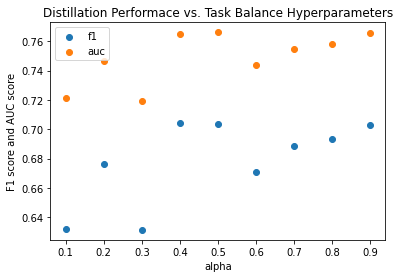

In [121]:
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
student_f1_list = []
student_auc_list = []
for alpha in alpha_list:
  student_model = student_initial()
  distiller = KD(student=student_model, teacher=teacher_model)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.BinaryAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=alpha,
      temperature = 4,
  )
  distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

  stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
  stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))

  student_f1_list.append(stu_f1_score)
  student_auc_list.append(stu_auc)

  print(alpha,'alpha done')
print('student_f1_list is',student_f1_list)
print('student_auc_list is',student_auc_list)
plt.scatter(alpha_list, student_f1_list, label='f1')
plt.scatter(alpha_list, student_auc_list, label='auc')
plt.xlabel("alpha")
plt.ylabel("F1 score and AUC score")
plt.title("Distillation Performace vs. Task Balance Hyperparameters")
plt.legend()
plt.show()

In [122]:
student_model = student_initial()

distiller = KD(student=student_model, teacher=teacher_model)
distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.BinaryAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.4,
      temperature = 4,
  )

distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 6s 31ms/step - binary_accuracy: 0.5938 - student_loss: 0.5446 - distillation_loss: 11.1004
Epoch 2/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.6724 - student_loss: 0.4064 - distillation_loss: 11.0942
Epoch 3/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7025 - student_loss: 0.3673 - distillation_loss: 11.0910
Epoch 4/25
68/68 [==============================] - 2s 30ms/step - binary_accuracy: 0.7083 - student_loss: 0.3559 - distillation_loss: 11.0903
Epoch 5/25
68/68 [==============================] - 2s 30ms/step - binary_accuracy: 0.7085 - student_loss: 0.3334 - distillation_loss: 11.0901
Epoch 6/25
68/68 [==============================] - 2s 31ms/step - binary_accuracy: 0.7092 - student_loss: 0.3200 - distillation_loss: 11.0900
Epoch 7/25
68/68 [==============================] - 2s 30ms/step - binary_accuracy: 0.7097 - student_loss: 0.3131 - distillation_loss: 11.0899

In [ ]:
stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student f1 score is',stu_f1_score)
stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student auc is',stu_auc)

31/31 [==============================] - 1s 12ms/step
Student f1 score is 0.7213114754098361
31/31 [==============================] - 0s 11ms/step
Student auc is 0.7791464073473798


#Results

In [129]:
teacherflops = get_flops(teacher_model)
studentflops = get_flops(student_model)
print('flops for teacher ResNet model is',teacherflops)
print('flops for student MobileNet model is',studentflops)

flops for teacher ResNet model is 6993968078
flops for student MobileNet model is 612731330


|                                | f1 Score | AUC Score | Number of Param. | FLOPs    |
|--------------------------------|----------|-----------|------------------|----------|
| Teacher Model                  | 0.75     | 0.80      | 3,852,966        | 7.0*10^9 |
| Student Trained from Scratch   | 0.69     | 0.76      | 2,562            | 6.1*10^8 |
| Student distilled from Teacher | 0.72     | 0.78      | 2,562            | 6.1*10^8 |